# Predicting House Prices with Machine Learning


## Introduction

This notebook is going to be focused on solving the problem of predicting house prices for house buyers and house sellers.

A house value is simply more than location and square footage. Like the features that make up a person, an educated party would want to know all aspects that give a house its value. 

We are going to take advantage of all of the feature variables available to use and use it to analyze and predict house prices.

We are going to break everything into logical steps that allow us to ensure the cleanest, most realistic data for our model to make accurate predictions from.

1. Load Data and Packages
2. Analyzing the Test Variable (Sale Price)
3. Multivariable Analysis
4. Impute Missing Data and Clean Data
5. Feature Transformation/Engineering
6. Modeling and Predictions


## 0. Understanding the Client and their Problem

A benefit to this study is that we can have two clients at the same time! (Think of being a divorce lawyer for both interested parties) However, in this case, we can have both clients with no conflict of interest!

Client Housebuyer: This client wants to find their next dream home with a reasonable price tag. They have their locations of interest ready. Now, they want to know if the house price matches the house value. With this study, they can understand which features (ex. Number of bathrooms, location, etc.) influence the final price of the house. If all matches, they can ensure that they are getting a fair price.

Client Houseseller: Think of the average house-flipper. This client wants to take advantage of the features that influence a house price the most. They typically want to buy a house at a low price and invest on the features that will give the highest return. For example, buying a house at a good location but small square footage. The client will invest on making rooms at a small cost to get a large return. 

## 1. Loading Data and Packages

In [218]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [219]:
# Load train and Test set
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [220]:
# Check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

# Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

# Now drop the 'Id' column since it's unnecessary for the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# Check data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


So the training set has 1460 rows and 81 features. The test set has 1459 rows and 80 features.

In [221]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [222]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


From looking at the head of both sets, we can see that the only difference in features is "Sale Price". This makes sense because we are trying to predict it!

## 2. Analyzing the Test Variable (Sale Price)

Let's check out the most interesting feature in this study: Sale Price. Important Note: This data is from Ames, Iowa. The location is extremely correlated with Sale Price. (I had to take a double-take at a point, since I consider myself a house-browsing enthusiast)

In [223]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [224]:
# Getting Description
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

With an average house price of $180921, it seems like I should relocated to Iowa!


 mu = 180921.20 and sigma = 79415.29



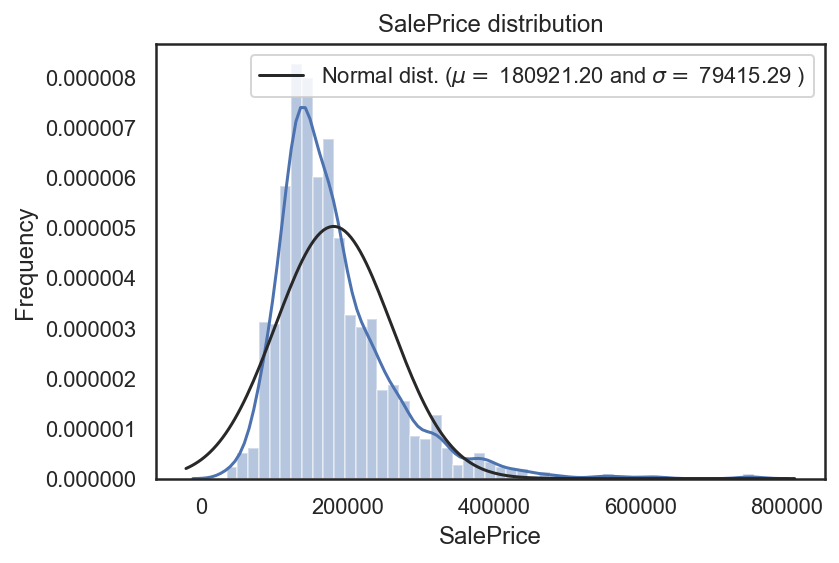

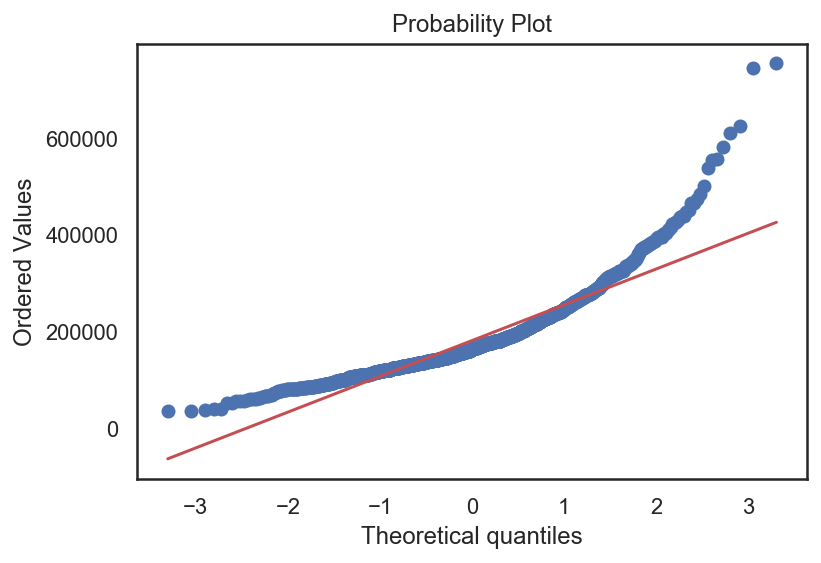

Skewness: 1.882876
Kurtosis: 6.536282


In [225]:
# Plot Histogram
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Looks like a normal distribution? Not quite! Looking at the kurtosis score, we can see that there is a very nice peak. However, looking at the skewness score, we can see that the sale prices deviate from the normal distribution. Going to have to fix this later! We want our data to be as "normal" as possible.

## 3. Multivariable Analysis

Let's check out all the variables! There are two types of features in housing data, categorical and numerical. 

Categorical data is just like it sounds. It is in categories. It isn't necessarily linear, but it follows some kind of pattern. For example, take a feature of "Downtown". The response is either "Near", "Far", "Yes", and "No".  Back then, living in downtown usually meant that you couldn't afford to live in uptown. Thus, it could be implied that downtown establishments cost less to live in. However, today, that is not the case. (Thank you, hipsters!) So we can't really establish any particular order of response to be "better" or "worse" than the other.

Numerical data is data in number form. (Who could have thought!) These features are in a linear relationship with each other. For example, a 2,000 square foot place is 2 times "bigger" than a 1,000 square foot place. Plain and simple. Simple and clean.

In [226]:
# Checking Categorical Data
train.select_dtypes(include=['object']).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [227]:
# Checking Numerical Data
train.select_dtypes(include=['int64','float64']).columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [228]:
cat = len(train.select_dtypes(include=['object']).columns)
num = len(train.select_dtypes(include=['int64','float64']).columns)
print('Total Features: ', cat, 'categorical', '+',
      num, 'numerical', '=', cat+num, 'features')

Total Features:  43 categorical + 37 numerical = 80 features


With 81 features, how could we possibly tell which feature is most related to house prices? Good thing we have a correlation matrix. Let's do it!

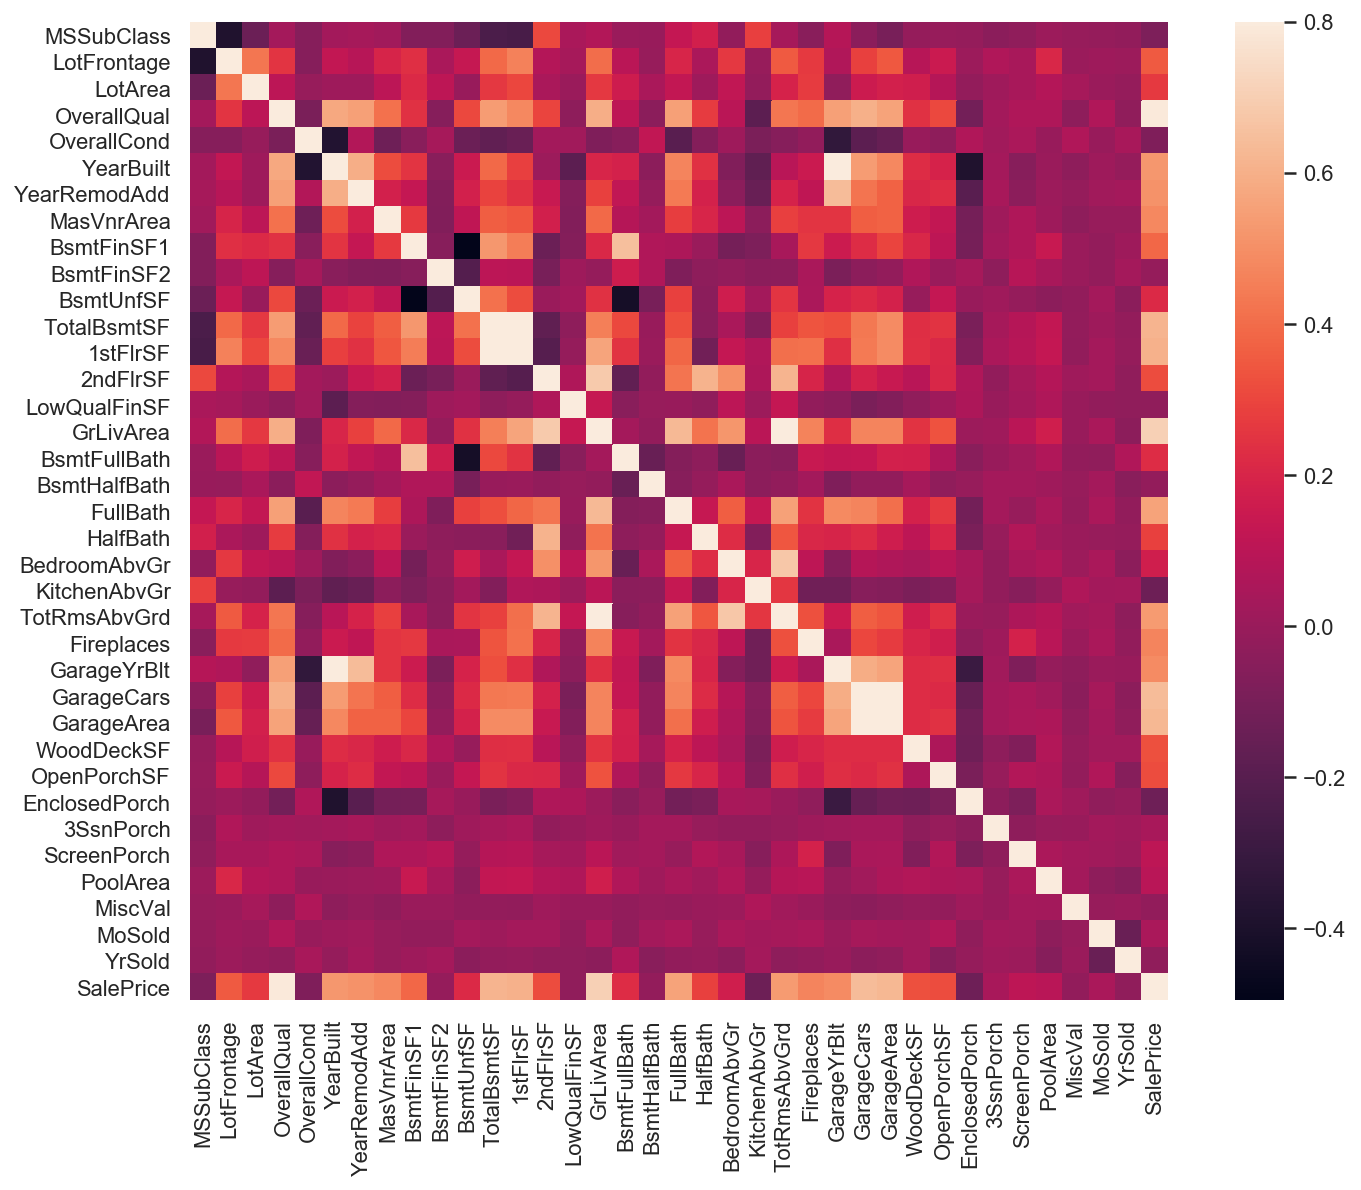

In [229]:
# Correlation Matrix Heatmap
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

It's a nice overview, but oh man is that a lot of data to look at. Let's zoom into the top 10 features most related to Sale Price.

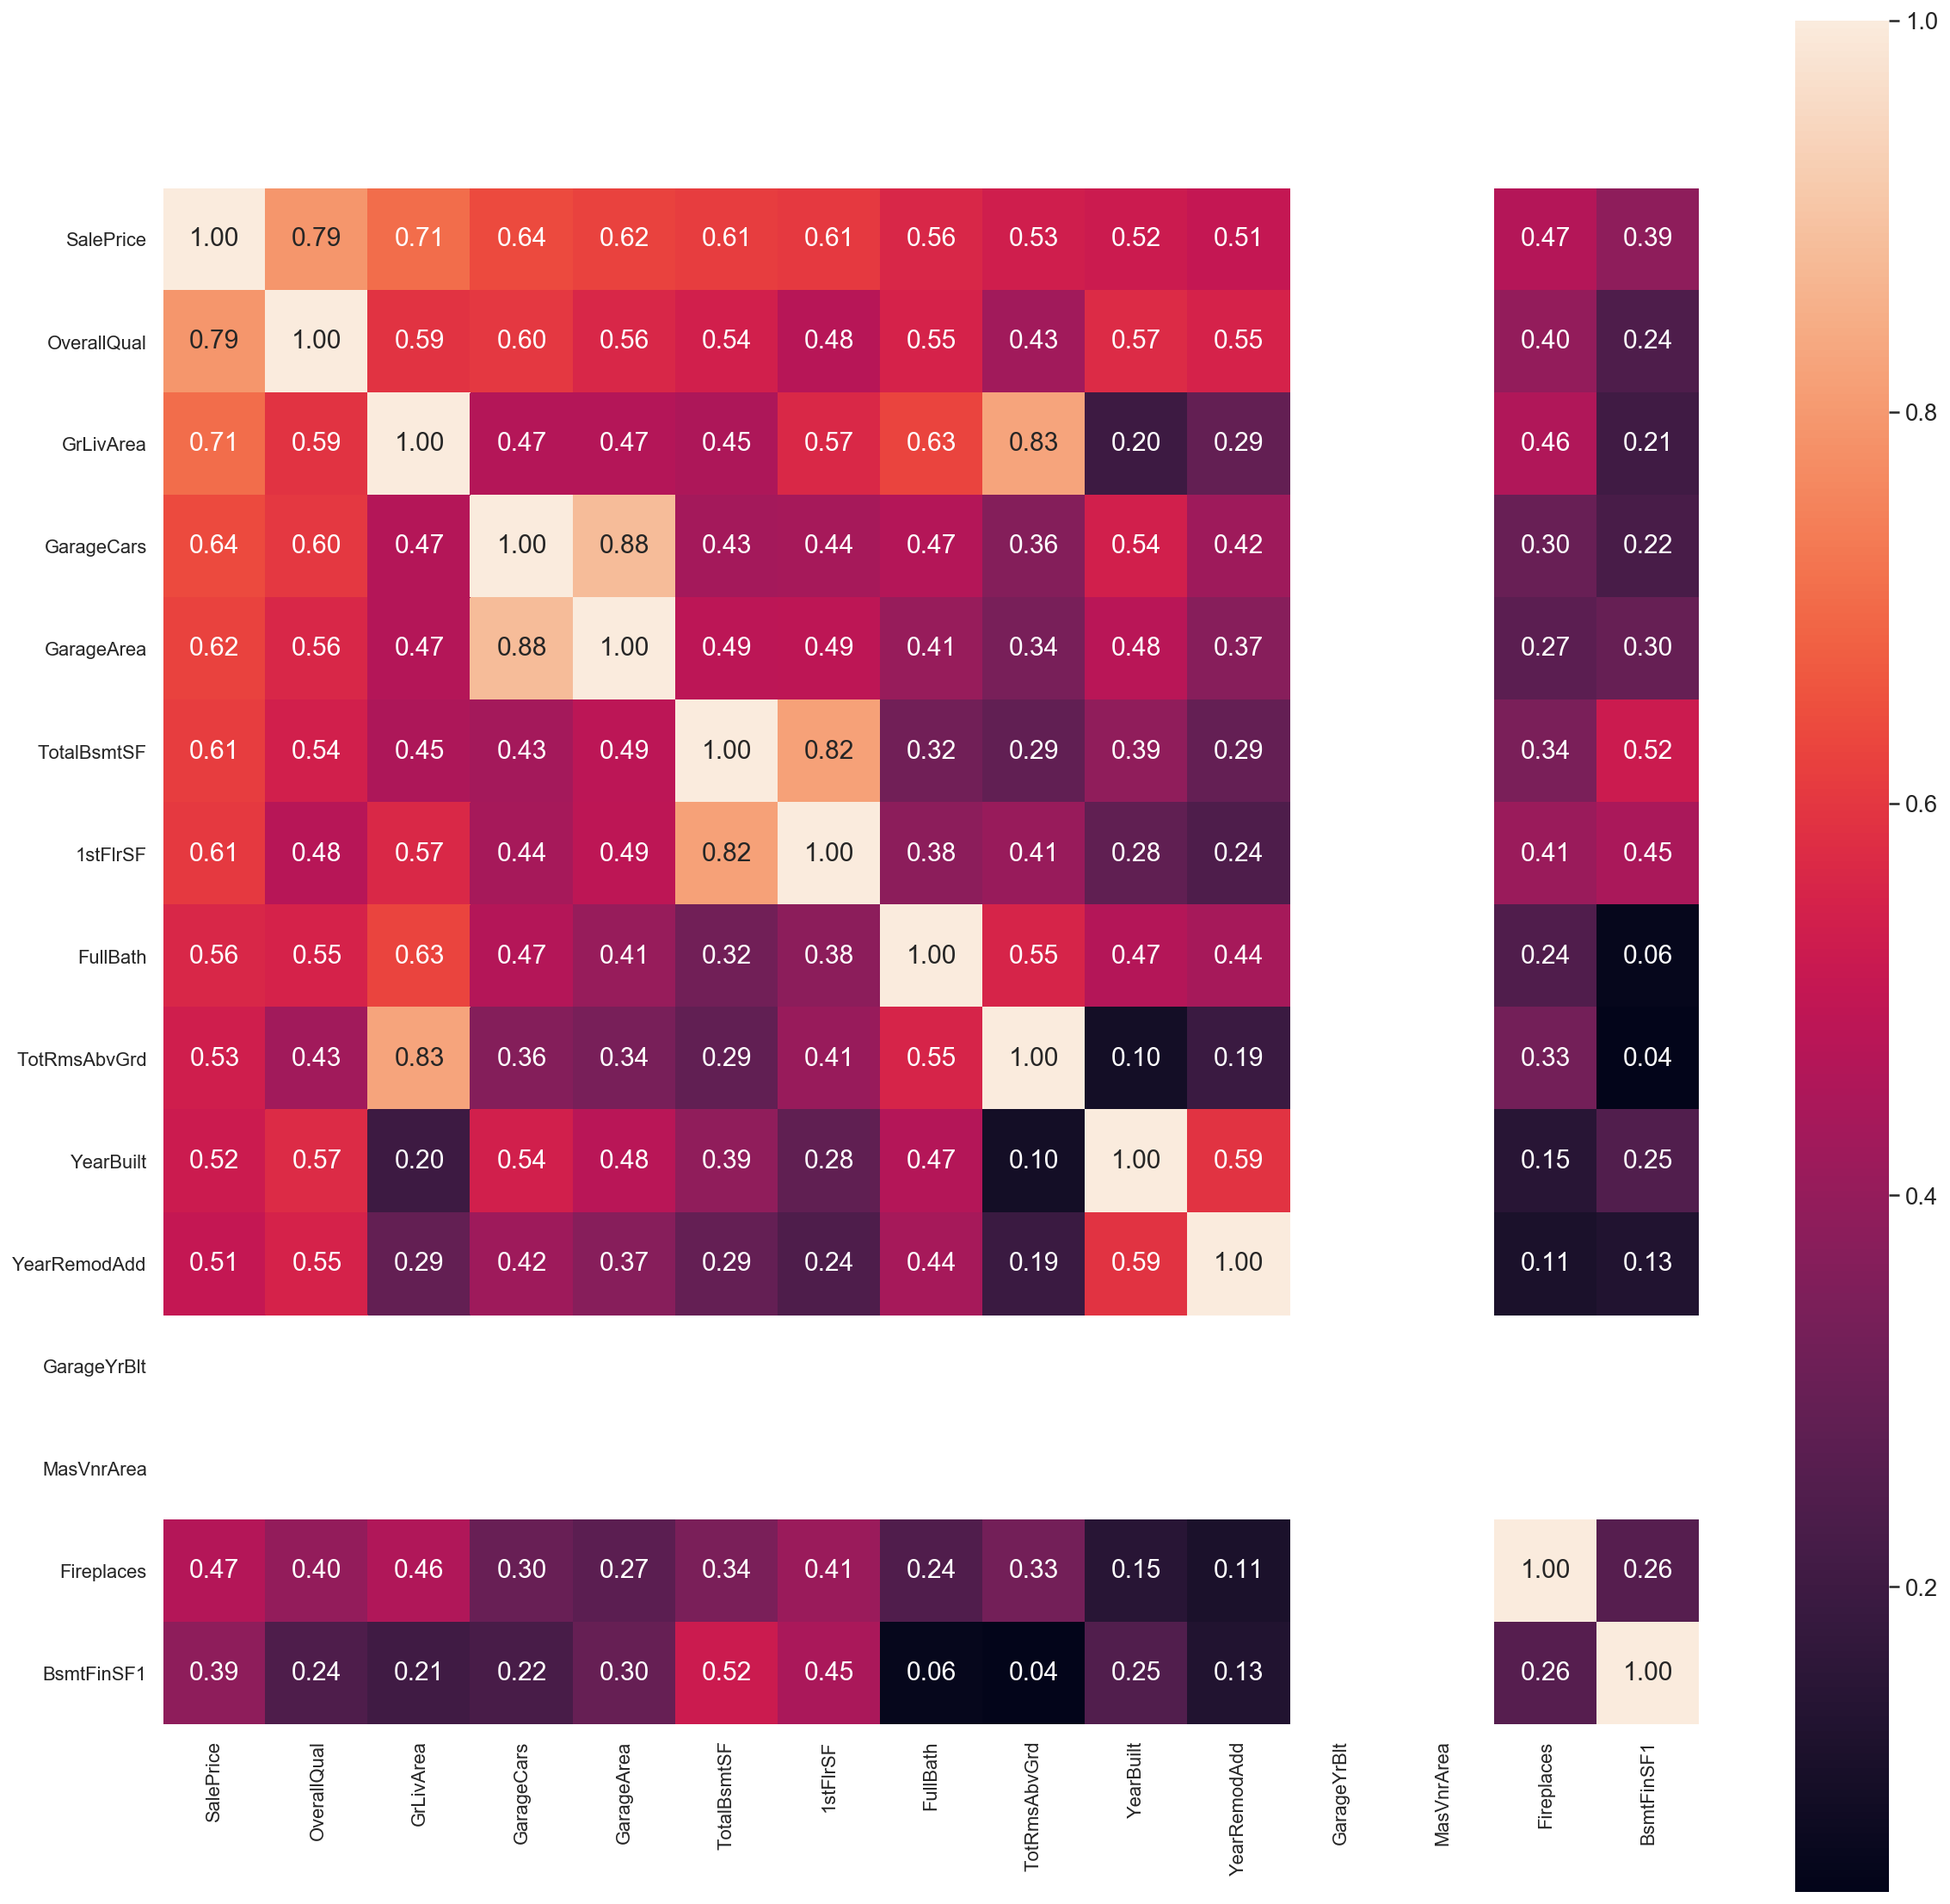

In [230]:
# Top 15 Heatmap
k = 15 #number of variables for heatmap
dims=(20,20)
fig,ax=plt.subplots(figsize=dims)
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cols1=(corrmat.nlargest(k, 'SalePrice')['SalePrice'].index).values.tolist()
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=cols.values, xticklabels=cols.values,ax=ax)
plt.show()

In [231]:
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
most_corr

,Most Correlated Features
0,SalePrice
1,OverallQual
2,GrLivArea
3,GarageCars
4,GarageArea
5,TotalBsmtSF
6,1stFlrSF
7,FullBath
8,TotRmsAbvGrd
9,YearBuilt


Well, the most correlated feature to Sale Price is... Sale Price?!? Of course. For the other 9, they are as listed. Here is a short description of each. (Thank you, data_description.txt!)

1. OverallQual: Rates the overall material and finish of the house (1 = Very Poor, 10 = Very Excellent)
2. GrLivArea: Above grade (ground) living area square feet
3. GarageCars: Size of garage in car capacity
4. GarageArea: Size of garage in square feet
5. TotalBsmtSF: Total square feet of basement area
6. 1stFlrSF: First Floor square feet
7. FullBath: Full bathrooms above grade
8. TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
9. YearBuilt: Original construction date

Let's take a look at how each relates to Sale Price and do some pre-cleaning on each feature if necessary.

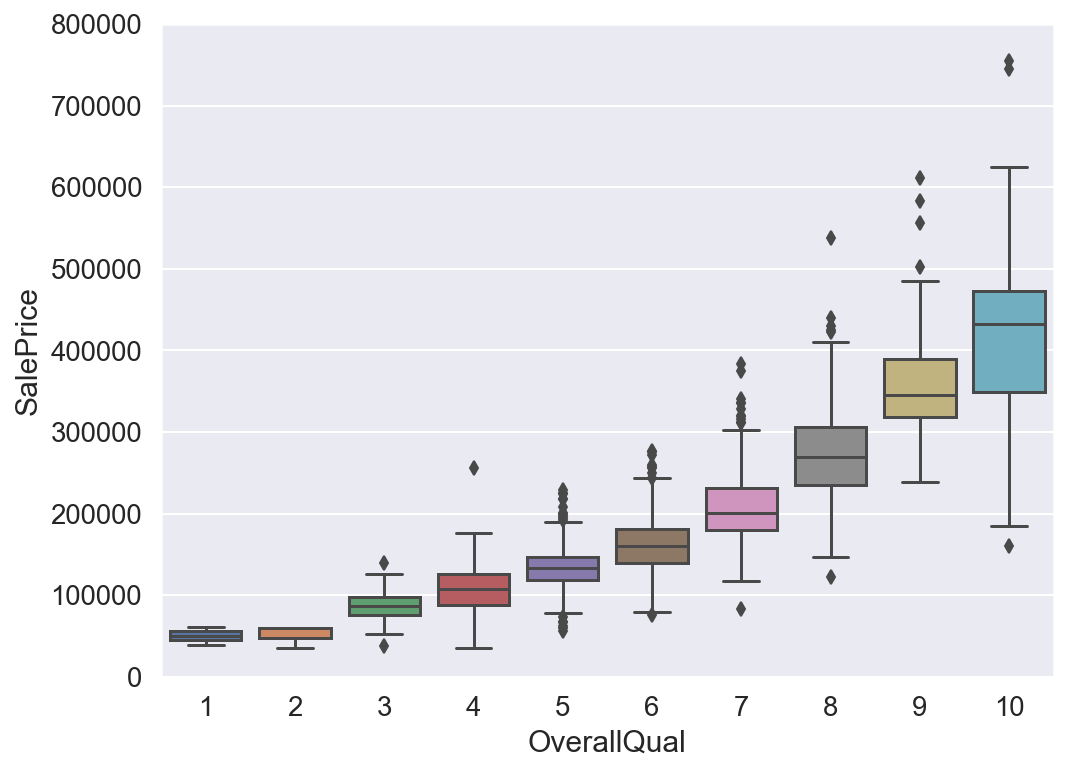

In [232]:
# Overall Quality vs Sale Price
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

What! People pay more for better quality? Nothing new here. Let's move on.

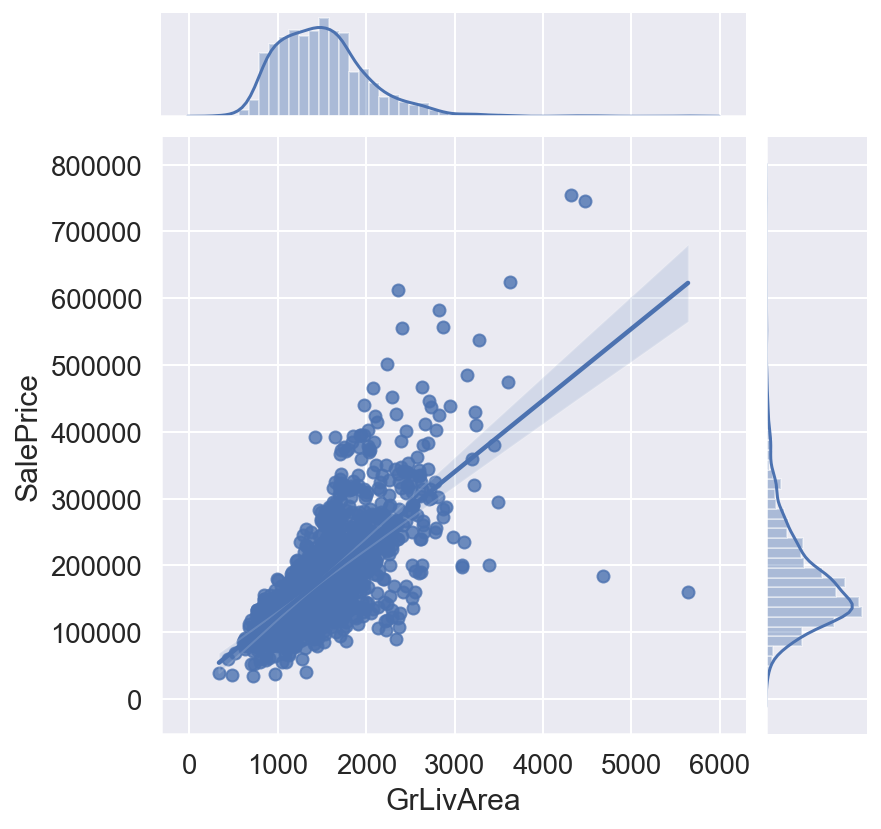

In [233]:
# Living Area vs Sale Price
sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'], kind='reg')

It makes sense that people would pay for the more living area. What doesn't make sense is the two datapoints in the bottom-right of the plot. 

 We need to take care of this! What we will do is remove these outliers manually. 

In [234]:
# Removing outliers manually (Two points in the bottom right)
train = train.drop(train[(train['GrLivArea']>4000) 
                         & (train['SalePrice']<300000)].index).reset_index(drop=True)

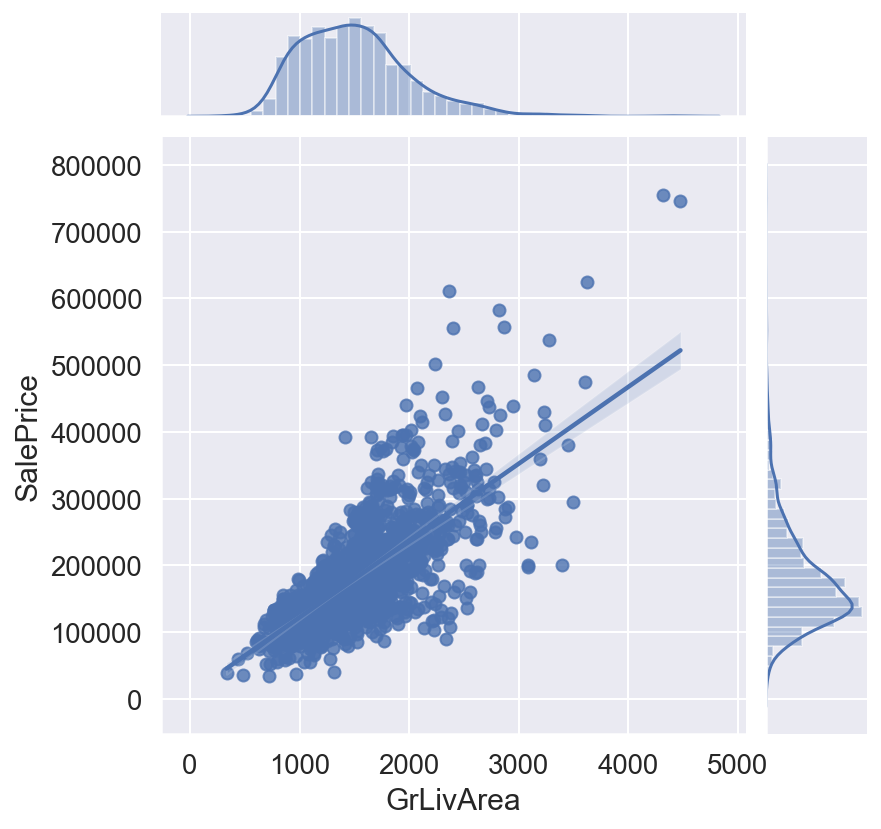

In [235]:
# Living Area vs Sale Price
sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'], kind='reg')

Nice! We got a 0.02 point increase in the Pearson-R Score.

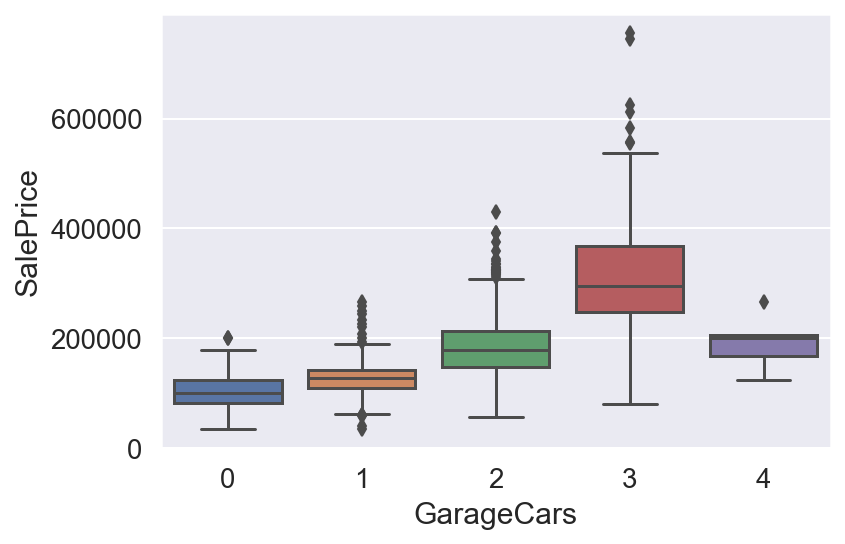

In [236]:
# Garage Area vs Sale Price
sns.boxplot(x=train['GarageCars'], y=train['SalePrice'])

4-car garages result in less Sale Price? That doesn't make much sense. Let's remove those outliers.

In [237]:
# Removing outliers manually (More than 4-cars, less than $300k)
train = train.drop(train[(train['GarageCars']>3) 
                         & (train['SalePrice']<300000)].index).reset_index(drop=True)

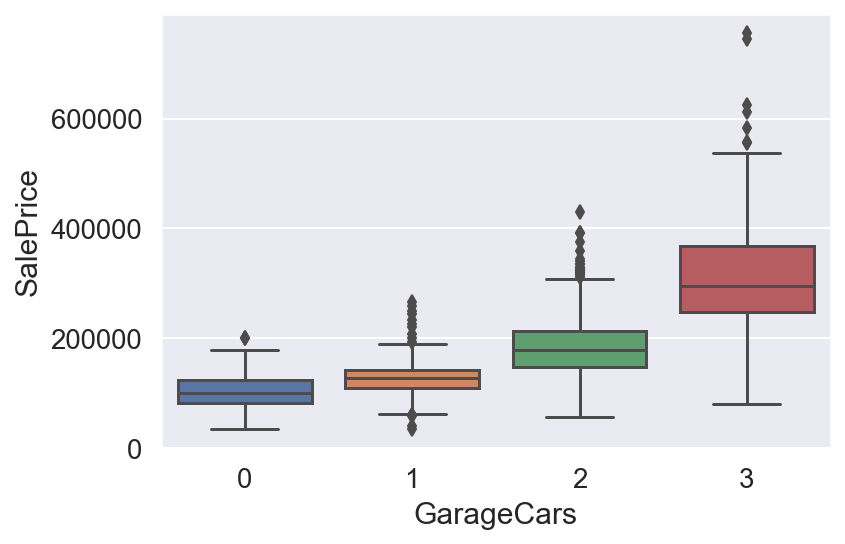

In [238]:
# Garage Area vs Sale Price
sns.boxplot(x=train['GarageCars'], y=train['SalePrice'])

That looks much better. Note: removal of data is totally discretionary and may or may not help in modeling. Use at your own preference.

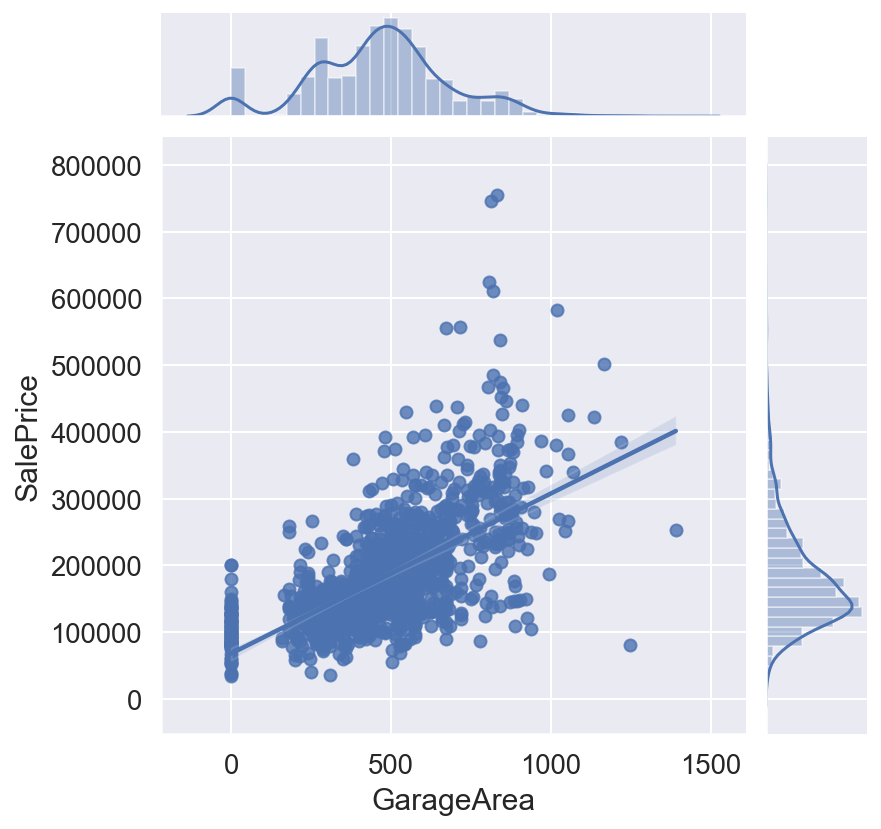

In [239]:
# Garage Area vs Sale Price
sns.jointplot(x=train['GarageArea'], y=train['SalePrice'], kind='reg')

Again with the bottom two data-points. Let's remove those outliers.

In [240]:
# Removing outliers manually (More than 1000 sqft, less than $300k)
train = train.drop(train[(train['GarageArea']>1000) 
                         & (train['SalePrice']<300000)].index).reset_index(drop=True)

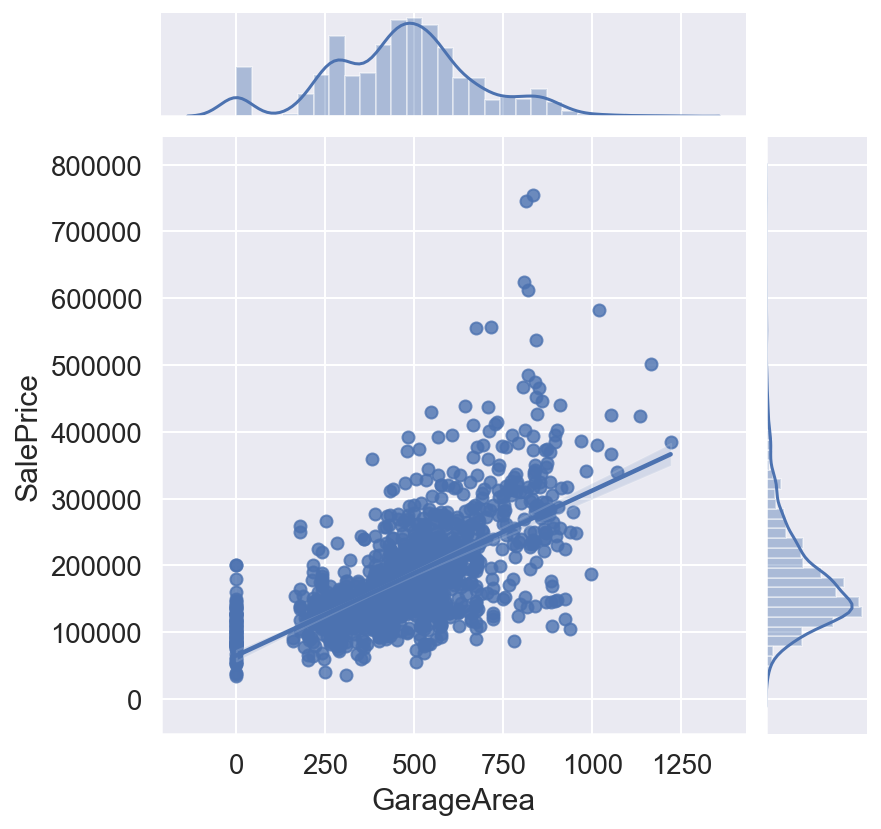

In [241]:
# Garage Area vs Sale Price
sns.jointplot(x=train['GarageArea'], y=train['SalePrice'], kind='reg')

Only 0.01 point Pearson-R Score increase, but looks much better!

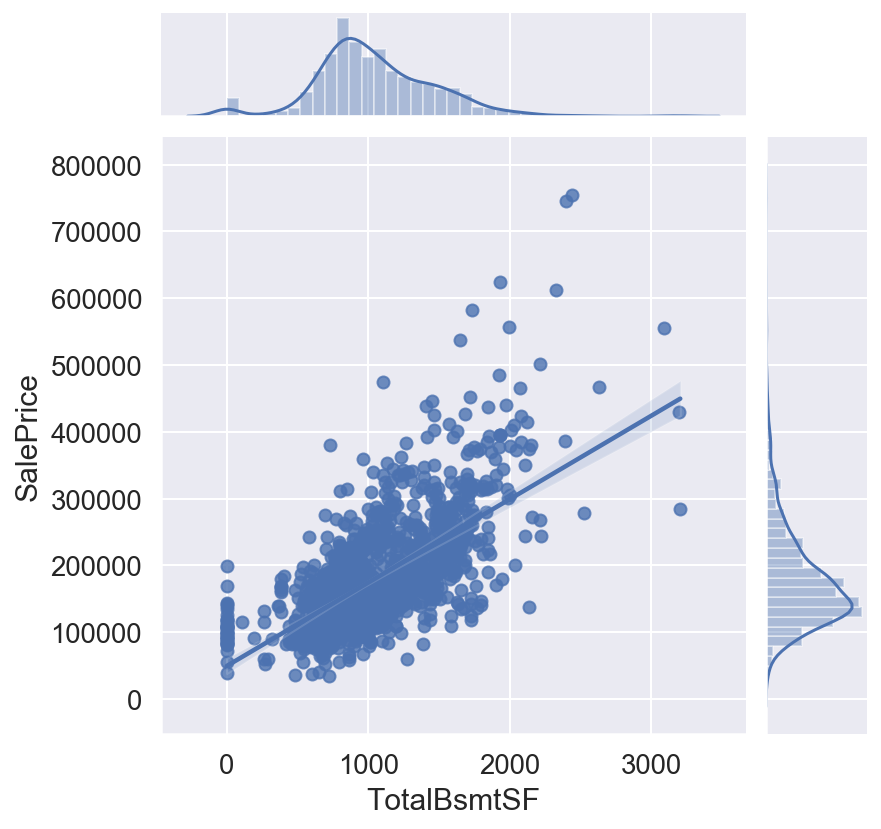

In [242]:
# Basement Area vs Sale Price
sns.jointplot(x=train['TotalBsmtSF'], y=train['SalePrice'], kind='reg')

Everything looks fine here.

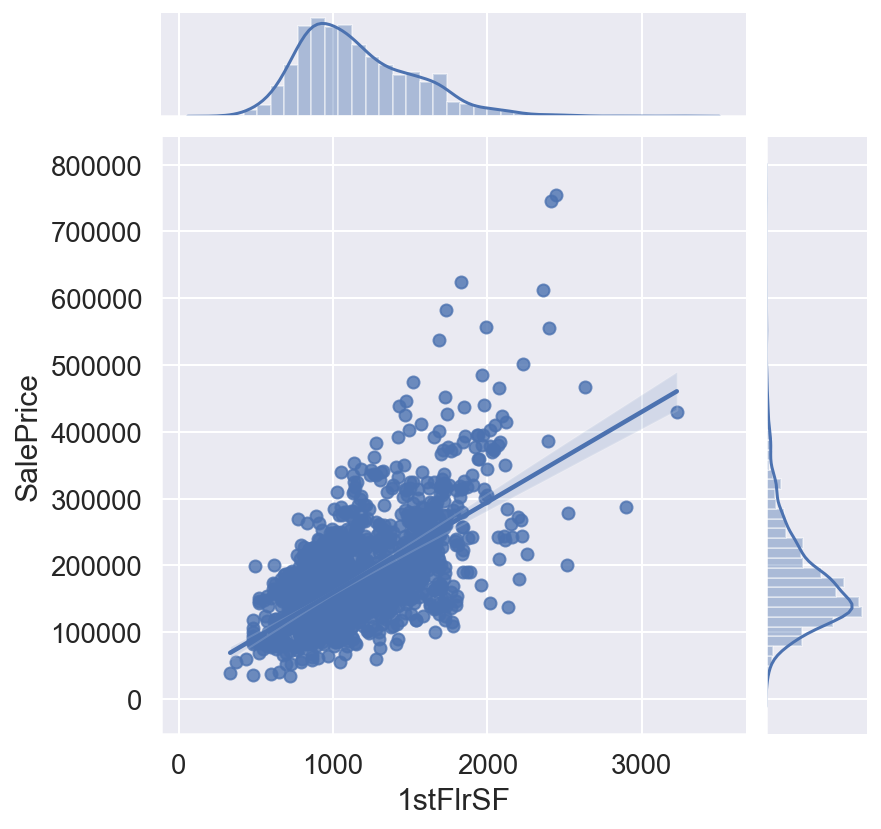

In [243]:
# First Floor Area vs Sale Price
sns.jointplot(x=train['1stFlrSF'], y=train['SalePrice'], kind='reg')

Looks good.

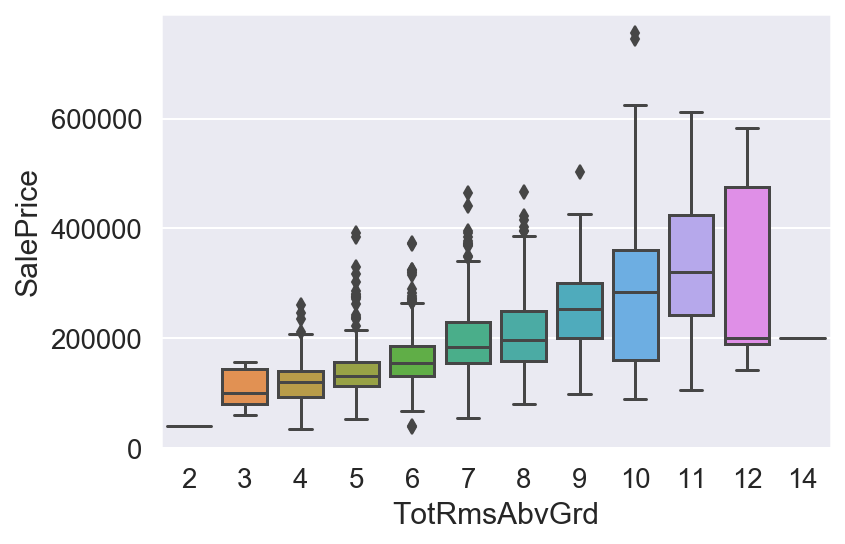

In [244]:
# Total Rooms vs Sale Price
sns.boxplot(x=train['TotRmsAbvGrd'], y=train['SalePrice'])

It seems like houses with more than 11 rooms come with a $100k off coupon. It looks like an outlier but I'll let it slide.

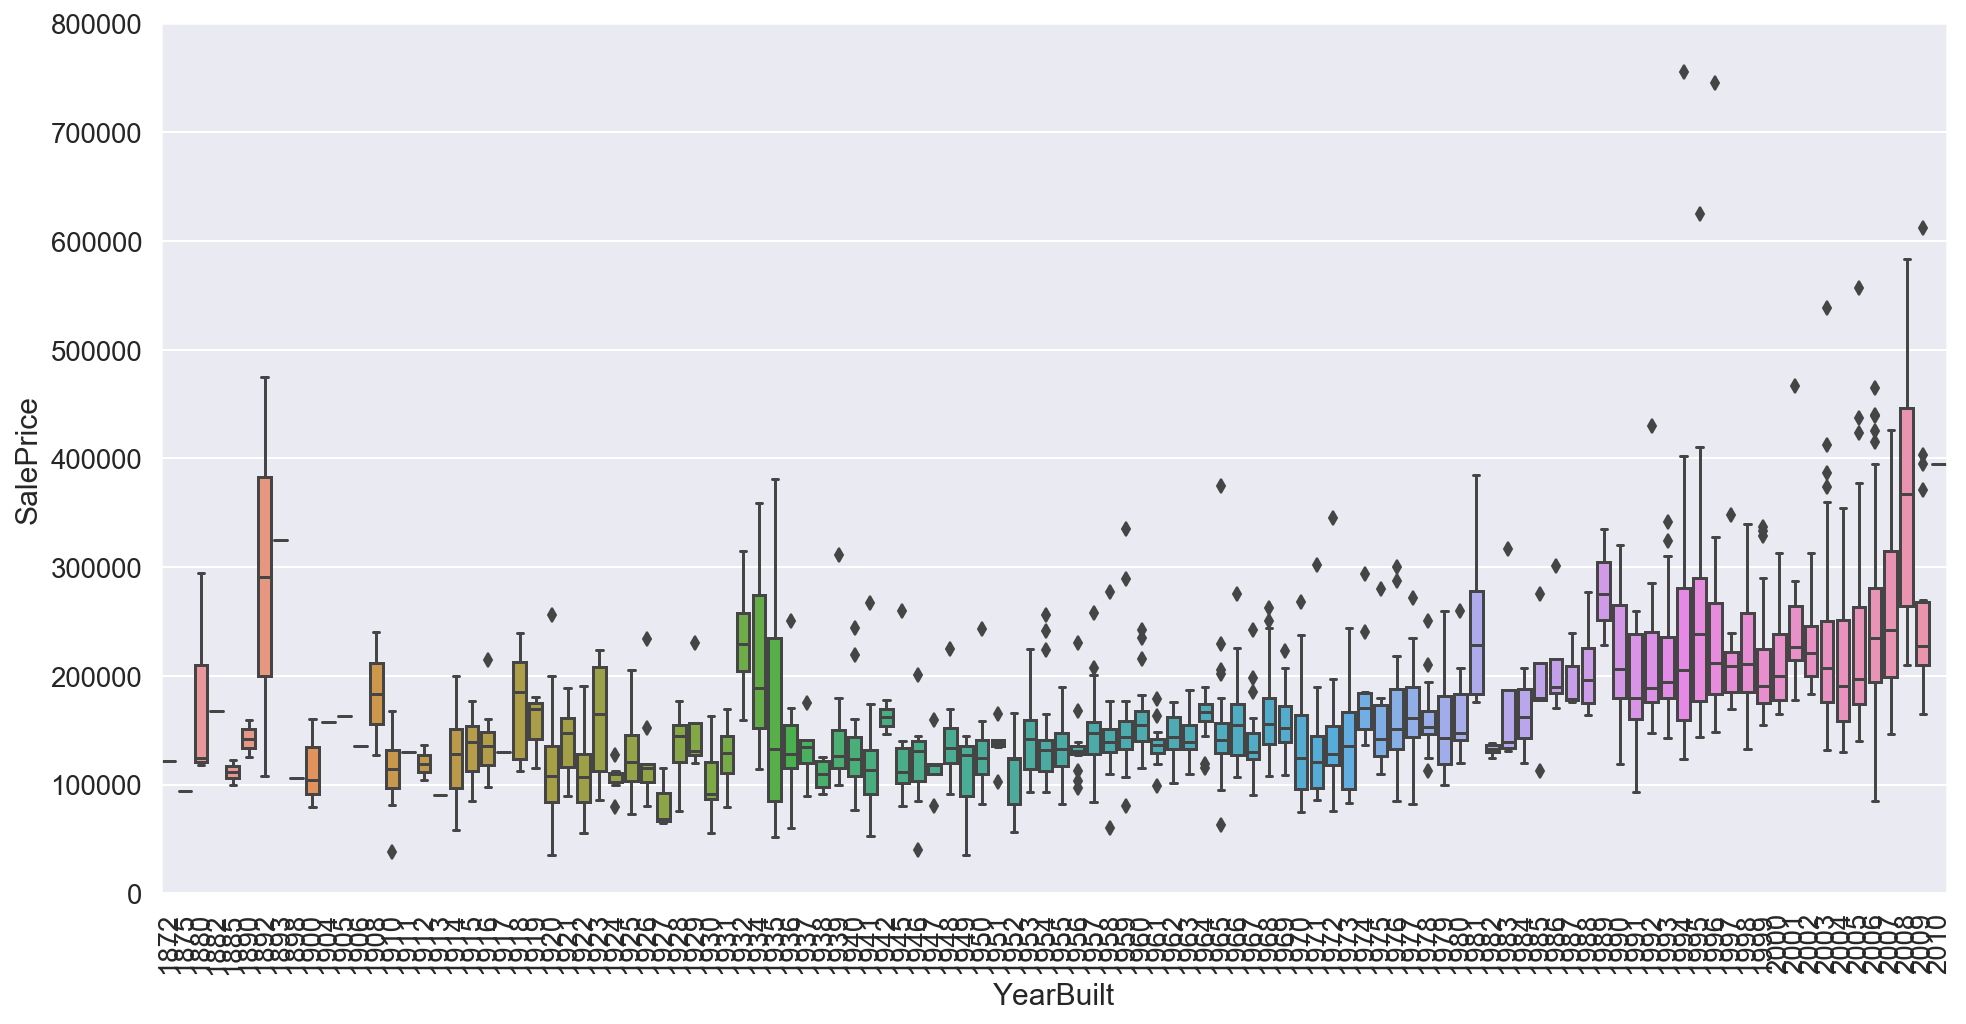

In [245]:
# Year Built vs Sale Price
var = 'YearBuilt'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

Although it seems like house prices decrease with age, we can't be entirely sure. Is it because of inflation or stock market crashes? Let's leave the years alone.

## 4. Impute Missing Data and Clean Data
Important questions when thinking about missing data:
* How prevalent is the missing data?
* Is missing data random or does it have a pattern?

The answer to these questions is important for practical reasons because missing data can imply a reduction of the sample size. This can prevent us from proceeding with the analysis. Moreover, from a substantive perspective, we need to ensure that the missing data process is not biased and hiding an inconvenient truth.

Let's combine both training and test data into one dataset to impute missing values and do some cleaning.

In [246]:
# Combining Datasets
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("Train data size is : {}".format(train.shape))
print("Test data size is : {}".format(test.shape))
print("Combined dataset size is : {}".format(all_data.shape))

Train data size is : (1448, 80)
Test data size is : (1459, 79)
Combined dataset size is : (2907, 79)


In [247]:
# Find Missing Ratio of Dataset
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio
PoolQC,99.690402
MiscFeature,96.422429
Alley,93.223254
Fence,80.392157
FireplaceQu,48.710010
LotFrontage,16.683867
GarageFinish,5.469556
GarageYrBlt,5.469556
GarageQual,5.469556
GarageCond,5.469556


Text(0.5, 1.0, 'Percent missing data by feature')

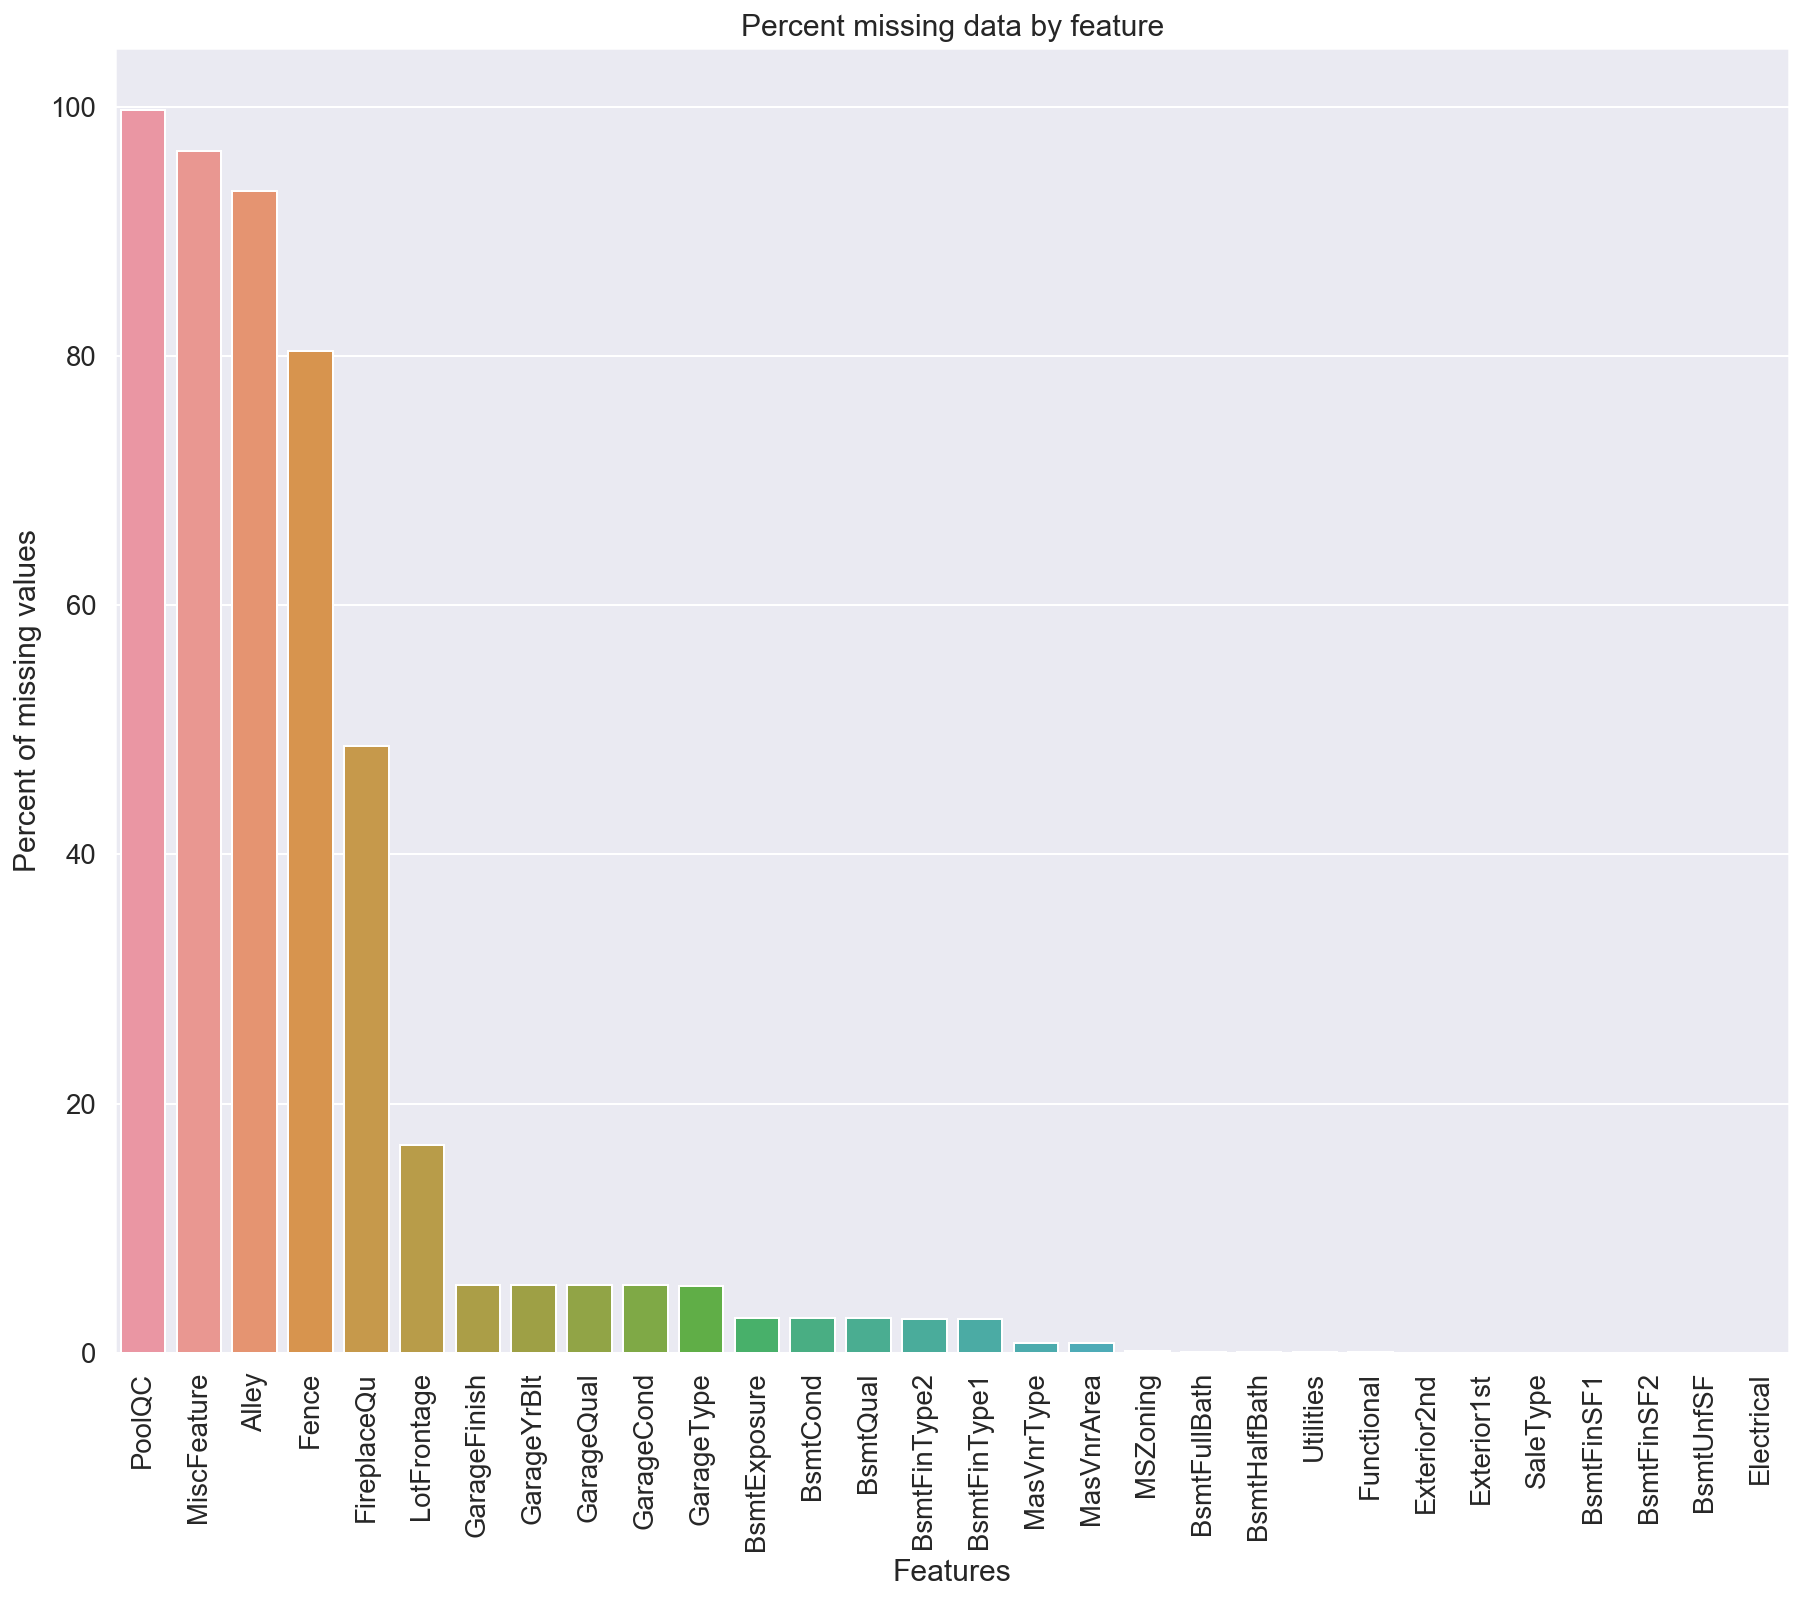

In [248]:
# Percent missing data by feature
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

### Imputing Missing Values
* PoolQC : data description says NA means "No Pool"
* MiscFeature : data description says NA means "no misc feature"
* Alley : data description says NA means "no alley access"
* Fence : data description says NA means "no fence"
* FireplaceQu : data description says NA means "no fireplace"
* LotFrontage : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.
* GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with "None".
* GarageYrBlt, GarageArea and GarageCars : Replacing missing data with 0.
* BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath: Replacing missing data with 0.
* BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : For all these categorical basement-related features, NaN means that there isn't a basement.
* MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.
* MSZoning (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'.
* Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.
* Functional : data description says NA means typical.
* Electrical : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
* KitchenQual: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.
* Exterior1st and Exterior2nd : Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
* SaleType : Fill in again with most frequent which is "WD"
* MSSubClass : Na most likely means No building class. We can replace missing values with None



In [249]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [250]:
# Check if there are any missing values left
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


## 5. Feature Transformation/Engineering

Let's take a look at some features that may be misinterpreted to represent something it's not.

MSSubClass: Identifies the type of dwelling involved in the sale.	
*         20	1-STORY 1946 & NEWER ALL STYLES
*         30	1-STORY 1945 & OLDER
*         40	1-STORY W/FINISHED ATTIC ALL AGES
*         45	1-1/2 STORY - UNFINISHED ALL AGES
*         50	1-1/2 STORY FINISHED ALL AGES
*         60	2-STORY 1946 & NEWER
*         70	2-STORY 1945 & OLDER
*         75	2-1/2 STORY ALL AGES
*         80	SPLIT OR MULTI-LEVEL
*         85	SPLIT FOYER
*         90	DUPLEX - ALL STYLES AND AGES
*        120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
*        150	1-1/2 STORY PUD - ALL AGES
*        160	2-STORY PUD - 1946 & NEWER
*        180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
*        190	2 FAMILY CONVERSION - ALL STYLES AND AGES


In [251]:
all_data['MSSubClass'].describe()

count    2907.000000
mean       57.094943
std        42.510238
min        20.000000
25%        20.000000
50%        50.000000
75%        70.000000
max       190.000000
Name: MSSubClass, dtype: float64

So, the average is a 57 type. What does that mean? Is a 90 type 3 times better than a 30 type? This feature was interpreted as numerical when it is actually categorical. The types listed here are codes, not values. Thus, we need to feature transformation with this and many other features.

In [252]:
#MSSubClass =The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In our previous example, we could tell that our categories don't follow a particular order. What about categories that do? Let's take a look at "Kitchen Quality".

In [253]:
all_data['KitchenQual'].unique()

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

Here, data_description.txt comes to the rescue again!

Kitchen Quality:
*        Ex:	Excellent
*        Gd:	Good
*        TA:	Typical/Average
*        Fa:	Fair
*        Po:	Poor

Is a score of "Gd" better than "TA" but worse than "Ex"? I think so, let's encode these labels to give meaning to their specific orders.

In [254]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# Process columns and apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# Check shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2907, 78)


1. Let's engineer one feature to combine square footage, this may be useful later on.

In [255]:
# Adding Total Square Feet feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

##### Checking fot any missing values in whole dataset.

In [256]:
cols1.remove('SalePrice')
all_data[cols1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2907 entries, 0 to 2906
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   2907 non-null   int64  
 1   GrLivArea     2907 non-null   int64  
 2   GarageCars    2907 non-null   float64
 3   GarageArea    2907 non-null   float64
 4   TotalBsmtSF   2907 non-null   float64
 5   1stFlrSF      2907 non-null   int64  
 6   FullBath      2907 non-null   int64  
 7   TotRmsAbvGrd  2907 non-null   int64  
 8   YearBuilt     2907 non-null   int64  
 9   YearRemodAdd  2907 non-null   int64  
 10  GarageYrBlt   2907 non-null   float64
 11  MasVnrArea    2907 non-null   float64
 12  Fireplaces    2907 non-null   int64  
 13  BsmtFinSF1    2907 non-null   float64
dtypes: float64(6), int64(8)
memory usage: 318.1 KB


## 6. Modeling and Predictions(Random Forest Regression)

In [257]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import math
import seaborn as sns

In [258]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train= train.SalePrice.values
train = pd.DataFrame(all_data[:ntrain])
test = pd.DataFrame(all_data[ntrain:])

In [259]:
# Checking train dataset
train=train[cols1]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448 entries, 0 to 1447
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1448 non-null   int64  
 1   GrLivArea     1448 non-null   int64  
 2   GarageCars    1448 non-null   float64
 3   GarageArea    1448 non-null   float64
 4   TotalBsmtSF   1448 non-null   float64
 5   1stFlrSF      1448 non-null   int64  
 6   FullBath      1448 non-null   int64  
 7   TotRmsAbvGrd  1448 non-null   int64  
 8   YearBuilt     1448 non-null   int64  
 9   YearRemodAdd  1448 non-null   int64  
 10  GarageYrBlt   1448 non-null   float64
 11  MasVnrArea    1448 non-null   float64
 12  Fireplaces    1448 non-null   int64  
 13  BsmtFinSF1    1448 non-null   float64
dtypes: float64(6), int64(8)
memory usage: 158.5 KB


In [260]:
# Checking test dataset
test=test[cols1]
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 1448 to 2906
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1459 non-null   int64  
 1   GrLivArea     1459 non-null   int64  
 2   GarageCars    1459 non-null   float64
 3   GarageArea    1459 non-null   float64
 4   TotalBsmtSF   1459 non-null   float64
 5   1stFlrSF      1459 non-null   int64  
 6   FullBath      1459 non-null   int64  
 7   TotRmsAbvGrd  1459 non-null   int64  
 8   YearBuilt     1459 non-null   int64  
 9   YearRemodAdd  1459 non-null   int64  
 10  GarageYrBlt   1459 non-null   float64
 11  MasVnrArea    1459 non-null   float64
 12  Fireplaces    1459 non-null   int64  
 13  BsmtFinSF1    1459 non-null   float64
dtypes: float64(6), int64(8)
memory usage: 159.7 KB


In [261]:
X_train=train
X_test=test
X_train.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,GarageYrBlt,MasVnrArea,Fireplaces,BsmtFinSF1
0,7,1710,2.0,548.0,856.0,856,2,8,2003,2003,2003.0,196.0,0,706.0
1,6,1262,2.0,460.0,1262.0,1262,2,6,1976,1976,1976.0,0.0,1,978.0
2,7,1786,2.0,608.0,920.0,920,2,6,2001,2002,2001.0,162.0,1,486.0
3,7,1717,3.0,642.0,756.0,961,1,7,1915,1970,1998.0,0.0,1,216.0
4,8,2198,3.0,836.0,1145.0,1145,2,9,2000,2000,2000.0,350.0,1,655.0


In [262]:
ss=StandardScaler()
X_train=ss.fit_transform(X_train)
X_test=ss.transform(X_test)

In [263]:
params = {
    "n_estimators": [10, 20, 30, 50, 100, 150, 200],
    "max_features": ["auto", "sqrt", "log2", None],
    "max_depth": list(range(2, 11)) + [None]
}
gs = GridSearchCV(estimator=RandomForestRegressor(), param_grid=params, cv=5, scoring="neg_mean_squared_error")
gs.fit(X_train, y_train)
gs.best_params_

Best Score: -708278774.946694


In [264]:
model = RandomForestRegressor(**gs.best_params_)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='log2', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [265]:
def evaluate(y, y_pred):
    y = list(map(math.log, y))
    y_pred = list(map(math.log, y_pred))
    return math.sqrt(mean_squared_error(y, y_pred))

scorer = make_scorer(evaluate)

In [266]:
print("Mean score:", cross_val_score(estimator=model, X=X_train, y=y_train, cv=5, scoring=scorer).mean())

Mean score: 0.14827147235937493


In [267]:
xtestpred=model.predict(X_test)
pd.DataFrame(xtestpred)

,0
0,123651.565
1,149573.500
2,179913.550
3,184515.450
4,190233.205
...,...
1454,81180.750
1455,88201.500
1456,155030.300
1457,107276.500


In [268]:
xtrainpred=model.predict(X_train)
finald=pd.DataFrame([xtrainpred,y_train]).transpose()
finald.columns=['predicted','original']
finald

,predicted,original
0,208374.175000,208500.0
1,176831.000000,181500.0
2,223424.765000,223500.0
3,155352.915000,140000.0
4,267008.995000,250000.0
...,...,...
1443,175295.500000,175000.0
1444,212882.920000,210000.0
1445,254515.250000,266500.0
1446,134448.350000,142125.0


In [269]:
import pickle
pickle.dump(model,open('model & scaler/rfrmodel.pkl','wb'))

In [270]:
pickle.dump(ss,open('model & scaler/scale.pkl','wb'))

In [271]:
# rf = RandomForestRegressor()
# paremeters_rf = {"n_estimators" : [5, 10, 15, 20], "criterion" : ["mse" , "mae"], "min_samples_split" : [2, 3, 5, 10], 
#                  "max_features" : ["auto", "log2"]}
# grid_rf = GridSearchCV(rf, paremeters_rf, verbose=1, scoring="r2")
# grid_rf.fit(X_train, y_train)

# print("Best RandomForestRegressor Model: " + str(grid_rf.best_estimator_))
# print("Best Score: " + str(grid_rf.best_score_))

In [272]:
# rf.fit(X_train, y_train)
# xtrainpred=rf.predict(X_train)
# finald=pd.DataFrame([xtrainpred,y_train]).transpose()
# finald.columns=['predicted','original']
# finald